In [1]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from tensorflow.keras.layers import Conv2D, Input, UpSampling2D, concatenate,Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.applications as apps

In [2]:
image_dir = '/kaggle/input/waterset/data/images'
label_dir = '/kaggle/input/waterset/data/labels'

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 12

In [4]:

images = []
labels = []


for filename in os.listdir(image_dir):
    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace('.tif', '.png'))

    # Read multi-channel TIFF image using rasterio
    with rasterio.open(img_path) as src:
        img = src.read()  # Read all channels
        img = np.moveaxis(img, 0, -1)  # Move channel axis to the end

    if img is None:
        print(f"Failed to load image: {img_path}")
        continue

    # Normalize image (assumes data is in range [0, 255])
    img = img / 255.0

    # Read grayscale label image using OpenCV
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    if label is None:
        print(f"Failed to load label: {label_path}")
        continue

    # Binarize label
    label_binary = (label > 0).astype(np.uint8)

    # Append to lists
    images.append(img)
    labels.append(label_binary)

x = np.array(images)
y = np.array(labels)
y = np.expand_dims(y, axis=-1)  

print("x_train shape:", x.shape)
print("y_train shape:", y.shape)

/opt/conda/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


x_train shape: (306, 128, 128, 12)
y_train shape: (306, 128, 128, 1)


In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Initialize ImageDataGenerator with augmentations
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=90,
    zoom_range=0.2
)

datagen.fit(x_train)


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (214, 128, 128, 12) (12 channels).
  warnings.warn(


In [7]:
def conv_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

In [8]:
def build_unet(input_shape):
    inputs = tf.keras.layers.Input(input_shape)
    
    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 128)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 256)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 512)
    
    u1 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u1 = tf.keras.layers.concatenate([u1, c3])
    u1 = conv_block(u1, 256)
    
    u2 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(u1)
    u2 = tf.keras.layers.concatenate([u2, c2])
    u2 = conv_block(u2, 128)
    
    u3 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(u2)
    u3 = tf.keras.layers.concatenate([u3, c1])
    u3 = conv_block(u3, 64)
    
    outputs = tf.keras.layers.Conv2D(1, kernel_size=1, activation="sigmoid")(u3)
    
    model = tf.keras.models.Model(inputs, outputs)
    return model


In [9]:
input_shape = (128, 128, 12)

In [10]:
model = build_unet(input_shape)

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [12]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ re_lu_3[0][0]   

 Total params: 3,799,169 (14.49 MB)

 Trainable params: 3,796,353 (14.48 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6          
)


In [14]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=16,callbacks=[reduce_lr])

Epoch 1/20


I0000 00:00:1726165127.614934      64 service.cc:145] XLA service 0x7ef610002810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726165127.614997      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/14 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.5371 - loss: 0.7345

I0000 00:00:1726165136.889693      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 701ms/step - accuracy: 0.7528 - loss: 0.4859 - val_accuracy: 0.6819 - val_loss: 0.5925 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.8874 - loss: 0.3153 - val_accuracy: 0.3522 - val_loss: 4.3021 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8989 - loss: 0.2825 - val_accuracy: 0.5281 - val_loss: 2.0924 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9021 - loss: 0.2564 - val_accuracy: 0.8915 - val_loss: 0.3906 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9139 - loss: 0.2347 - val_accuracy: 0.5813 - val_loss: 0.8791 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9080 - loss: 0.2309 - val_accuracy: 0.8952 - val_loss: 0.3259 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9040 - loss: 0.2445 - val_accuracy: 0.

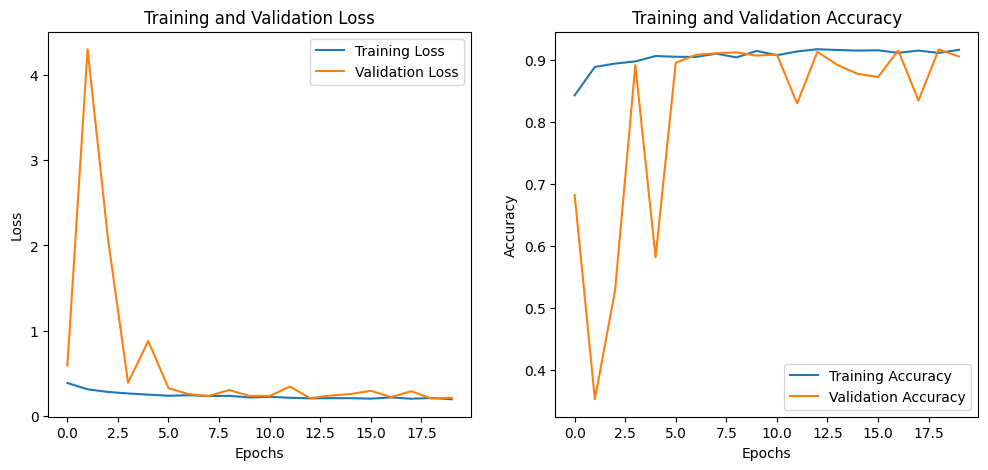

In [15]:
loss_acc_metrics_df = pd.DataFrame(history.history)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_acc_metrics_df['loss'], label='Training Loss')
plt.plot(loss_acc_metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loss_acc_metrics_df['accuracy'], label='Training Accuracy')
plt.plot(loss_acc_metrics_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9034 - loss: 0.2174
Test Loss: 0.2136353850364685
Test Accuracy: 0.905386209487915


In [17]:
def visualize_predictions(x_test, y_test, model):
    idx = np.random.randint(0, len(x_test))
    predicted_mask = model.predict(x_test[idx].reshape(1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title('Input Image')
    plt.imshow(x_test[idx][:, :, :3])  # Display first 3 channels as RGB
    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(y_test[idx].reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask.reshape(IMG_HEIGHT, IMG_WIDTH), cmap='gray')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


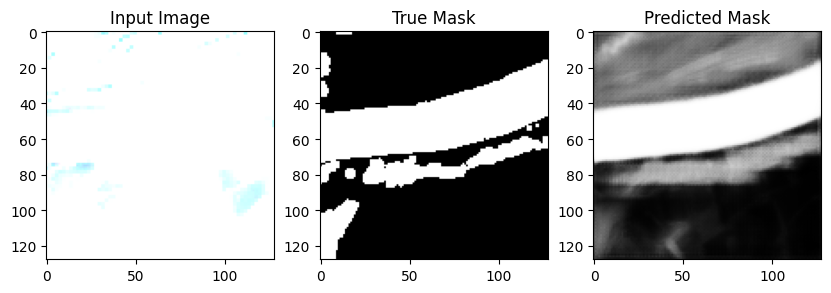

In [18]:
visualize_predictions(x_test, y_test, model)

**Pretrained Model - DeepLabV3**

In [19]:
def get_deeplabv3_model(input_shape):
    
    base_model = tf.keras.applications.DenseNet121(
        input_shape=input_shape,
        include_top=False,
        weights=None
    )

    
    inputs = Input(shape=(input_shape[0], input_shape[1], 12))
    
    
    x = Conv2D(3, (1, 1))(inputs)
    
    
    x = base_model(x)

    
    layer_1 = base_model.get_layer('conv1_relu').output  # Shape (64, 64, 64)
    layer_2 = base_model.get_layer('pool1').output  # Shape (32, 32, 64)
    layer_3 = base_model.get_layer('conv2_block4_0_bn').output  # Shape (32, 32, 160)
    
    
    upsampled_layer_2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(layer_2)
    upsampled_layer_3 = UpSampling2D(size=(2, 2), interpolation='bilinear')(layer_3)

   
    concatenated = concatenate([layer_1, upsampled_layer_2, upsampled_layer_3])
    x = Dropout(0.5)(x)
    
    
    x = Conv2D(1, (1, 1), activation='sigmoid')(concatenated)

    
    output = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    
    
    model = Model(inputs=inputs, outputs=output)
    
    return model

In [20]:
pretrained_model = get_deeplabv3_model((IMG_HEIGHT, IMG_WIDTH, 3))

In [21]:
pretrained_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ re_lu_2[0][0]     │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    524,544 │ re_lu_3[0][0]   

 Total params: 11,391,877 (43.46 MB)

 Trainable params: 3,796,353 (14.48 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 7,592,708 (28.96 MB)

In [23]:
pretrained_history = model.fit(x_train, y_train, batch_size=16, epochs=50, validation_data=(x_test, y_test),callbacks=[reduce_lr])

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9212 - loss: 0.1900 - val_accuracy: 0.9186 - val_loss: 0.2149 - learning_rate: 5.0000e-04
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9273 - loss: 0.1715 - val_accuracy: 0.8847 - val_loss: 0.2532 - learning_rate: 5.0000e-04
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9218 - loss: 0.1857 - val_accuracy: 0.9194 - val_loss: 0.1995 - learning_rate: 5.0000e-04
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9269 - loss: 0.1800 - val_accuracy: 0.9188 - val_loss: 0.2093 - learning_rate: 5.0000e-04
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9149 - loss: 0.2005 - val_accuracy: 0.9213 - val_loss: 0.1942 - learning_rate: 5.0000e-04
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9228 - loss: 0.1840 - val_accuracy: 0.9166 - val_loss: 0.2099 - learning_rate: 5.0000e-04
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9030 

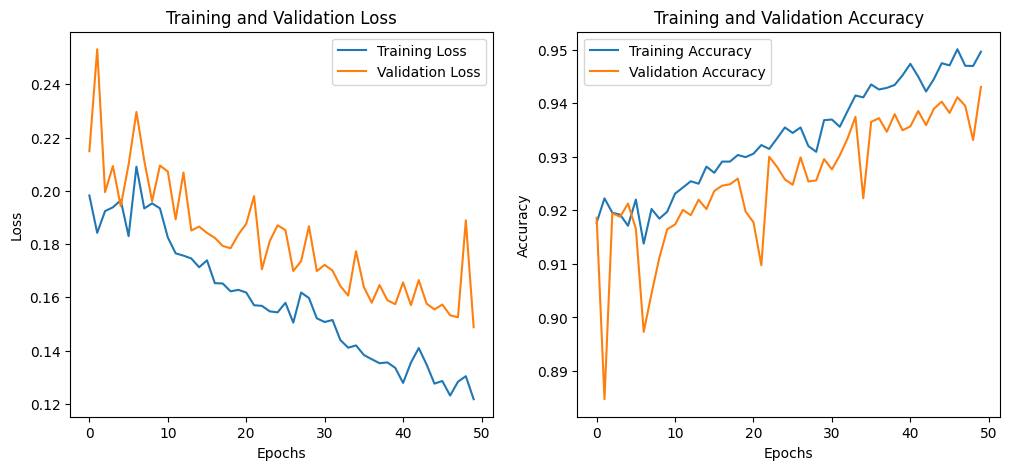

In [24]:
loss_acc_metrics_df = pd.DataFrame(pretrained_history.history)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_acc_metrics_df['loss'], label='Training Loss')
plt.plot(loss_acc_metrics_df['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loss_acc_metrics_df['accuracy'], label='Training Accuracy')
plt.plot(loss_acc_metrics_df['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [25]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9407 - loss: 0.1515
Test Loss: 0.1487855762243271
Test Accuracy: 0.9430349469184875
